In [71]:
from sklearn.cluster import KMeans
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
import pickle as pkl
from sklearn.cluster import DBSCAN

In [72]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [73]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    text = emoji_pattern.sub(r'', str(text))
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu()

def parse_json(data):
    return list(embed_bert_cls(data["title"], model, tokenizer))[:100] \
        + list(embed_bert_cls(data["maintext"], model, tokenizer))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
with open('parsed_news.json', 'rb') as f:
    data = json.load(f)

In [78]:
title = []
main_text = []
embeds = []
sources = []
urls = []

for news in data:
    sources.append(news['source_domain'])
    urls.append(news['url'])
    title.append(news['title'])
    main_text.append(news['maintext'])
    embeds.append(parse_json(news))
df = pd.DataFrame({'title' : title
                 , 'main_text' : main_text
                 , 'embed' : embeds
                 , 'source' : sources
                 , 'url' : urls})

In [79]:
df['embeds'] = list([[float(i) for i in s] for s in df['embed']])

In [80]:
df.drop(columns=['embed'], inplace=True)

In [81]:
feats_emb = [f'emb_{str(i)}' for i in range(412)]

In [82]:
for i, feat in enumerate(feats_emb):
    df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]

C:\Users\danie\AppData\Local\Temp\ipykernel_2960\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]
C:\Users\danie\AppData\Local\Temp\ipykernel_2960\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat] = [df['embeds'][j][i] for j in range(df.shape[0])]
C:\Users\danie\AppData\Local\Temp\ipykernel_2960\1079347849.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [83]:
dist_matr = cosine_similarity(df[feats_emb], df[feats_emb])

In [84]:
for i in range(dist_matr.shape[0]):
    dist_matr[i][i] = 0

In [85]:
s = set()
for i in range(dist_matr.shape[0]):
    s.update(list(dist_matr[i][i+1:]))

In [86]:
dists = np.array(sorted(list(s)))

In [87]:
threshold = np.quantile(dists, q=0.99)

In [88]:
near_texts = []
n = dist_matr.shape[0]
for i in range(n):
    for j in range(n):
        if dist_matr[i][j] > threshold:
            near_texts.append({'dist' : dist_matr[i][j]
                             , 'id_1' : i
                             , 'title_1' : df.iloc[i]['title']
                             , 'text_1' : df.iloc[i]['main_text']
                             , 'url_1' : df.iloc[i]['url']
                             , 'id_2' : j
                             , 'title_2' : df.iloc[j]['title']
                             , 'text_2' : df.iloc[j]['main_text']
                             , 'url_2' : df.iloc[j]['url']})

In [89]:
near_texts.__len__()#[2000]

54314

In [90]:
df

,title,main_text,source,url,embeds,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_402,emb_403,emb_404,emb_405,emb_406,emb_407,emb_408,emb_409,emb_410,emb_411
0,Компанию оштрафовали на 1 млн рублей за взятку...,🏢👨🚚🚔📄💵💣👎💰❗\nКомпания из Пензы занималась нефте...,journal.tinkoff.ru,https://journal.tinkoff.ru/omg/1-mln-za-vzyatku/,"[0.03701384365558624, -0.06921613961458206, -0...",0.037014,-0.069216,-0.059091,-0.009989,0.025910,...,0.020840,-0.044019,-0.010853,0.104024,-0.012741,0.007446,0.046363,-0.067669,-0.004650,-0.042104
1,Ваш бизнес получил поддержку от государства? П...,"По данным Минэкономразвития на 24 апреля, пред...",journal.tinkoff.ru,https://journal.tinkoff.ru/state-support-form/,"[0.048191823065280914, -0.03813547641038895, -...",0.048192,-0.038135,-0.004023,-0.084714,0.038693,...,0.057051,-0.099931,-0.031276,0.043183,-0.004697,-0.017725,0.071623,-0.054437,0.020523,-0.020326
2,что можно получить от государства,В 2022 году бизнес в России страдает от послед...,journal.tinkoff.ru,https://journal.tinkoff.ru/thank-you-russia/,"[0.04402726888656616, -0.08827033638954163, -0...",0.044027,-0.088270,-0.038862,-0.047465,0.002809,...,0.099108,-0.105293,-0.037132,0.056390,0.024668,-0.028653,0.087916,-0.028711,0.016805,-0.009802
3,подборка важных изменений,С 1 января 2021 года вступают в силу новые зак...,journal.tinkoff.ru,https://journal.tinkoff.ru/short/business-2021/,"[-0.0511656254529953, -0.00198711478151381, 0....",-0.051166,-0.001987,0.011554,-0.075959,-0.040049,...,0.061351,-0.063093,-0.002080,0.073409,0.050835,-0.021381,0.067105,-0.053787,-0.010381,-0.012909
4,Что такое камеральная проверка,"Чтобы контролировать, соблюдает ли налогоплате...",journal.tinkoff.ru,https://journal.tinkoff.ru/guide/in-house-audit/,"[-0.022323574870824814, -0.018657026812434196,...",-0.022324,-0.018657,0.009475,-0.086730,0.034692,...,0.072735,-0.063010,-0.038807,0.052985,-0.013150,-0.006831,0.062546,-0.061691,0.001232,-0.020789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,Сбербанк уже оформляет кредитные каникулы для ...,Клиенты-военнослужащие могут оформить отсрочку...,www.klerk.ru,https://www.klerk.ru/buh/news/537135/,"[0.0498785637319088, -0.1037084311246872, -0.0...",0.049879,-0.103708,-0.062167,-0.050818,0.040345,...,0.065358,-0.062023,0.002131,0.054292,-0.011680,-0.033124,0.061809,-0.025045,0.040298,-0.036134
2328,Штраф за неуплату НДФЛ можно снизить или вообщ...,Обсуждение затеяли наши подписчики в канале «К...,www.klerk.ru,https://www.klerk.ru/buh/news/537137/,"[0.014039666391909122, -0.05027339607477188, -...",0.014040,-0.050273,-0.061727,-0.102627,0.055682,...,0.065315,-0.077641,-0.029051,0.060365,0.023020,-0.017469,0.053358,-0.073251,0.026887,-0.019232
2329,С 1 марта 2023 года можно будет оформлять элек...,"Бухгалтеры, переучивайтесь на маркетологов и з...",www.klerk.ru,https://www.klerk.ru/buh/news/537141/,"[0.006541747134178877, -0.06832202523946762, -...",0.006542,-0.068322,-0.043525,-0.013888,0.008082,...,0.056476,-0.093378,-0.053230,0.069190,0.025423,0.002253,0.055800,-0.037518,0.003719,-0.024736
2330,Порядок сверки расчетов по налогам отменили. Н...,До недавнего времени был временный порядок све...,www.klerk.ru,https://www.klerk.ru/buh/news/537147/,"[0.019377605989575386, -0.011238849721848965, ...",0.019378,-0.011239,-0.083196,-0.027339,-0.011893,...,0.034228,-0.039579,0.007110,0.043094,-0.027102,0.011379,0.028768,-0.105590,0.055404,-0.041691


In [91]:
df[df['source'] == 'www.klerk.ru']['main_text']

1352    Глубокий анализ данных помогает видеть законом...
1353    «Газпром» подписал соглашение с Китаем о расче...
1354    Ограничительная мера распространяется на сделк...
1355    Регулятор выпустил информационное письмо с рек...
1356    Речь идет о перечне перечень должностей, при н...
                              ...                        
2327    Клиенты-военнослужащие могут оформить отсрочку...
2328    Обсуждение затеяли наши подписчики в канале «К...
2329    Бухгалтеры, переучивайтесь на маркетологов и з...
2330    До недавнего времени был временный порядок све...
2331    Бухгалтеры, переучивайтесь на маркетологов и з...
Name: main_text, Length: 980, dtype: object

In [92]:
ids = set()
for i in range(near_texts.__len__()):
    ids.add(near_texts[i]['id_1'])
    ids.add(near_texts[i]['id_2'])
print(ids.__len__())

957


In [93]:
n_clusters = 4
clustering = KMeans(n_clusters=n_clusters)
clusters = clustering.fit_predict(df[feats_emb])


In [94]:
with open('clustering', 'wb') as f:
    pkl.dump(clustering, f)


In [95]:
df['clust_4'] = clusters

In [51]:
#df[df['clust_4'] == 0]['source'].unique()
df[df['clust_4'] == 0]['main_text'].nunique()

27

In [43]:
df

,title,main_text,source,url,embeds,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_403,emb_404,emb_405,emb_406,emb_407,emb_408,emb_409,emb_410,emb_411,clust_4
0,Компанию оштрафовали на 1 млн рублей за взятку...,🏢👨🚚🚔📄💵💣👎💰❗\nКомпания из Пензы занималась нефте...,journal.tinkoff.ru,https://journal.tinkoff.ru/omg/1-mln-za-vzyatku/,"[0.03701384365558624, -0.06921613961458206, -0...",0.037014,-0.069216,-0.059091,-0.009989,0.025910,...,-0.044019,-0.010853,0.104024,-0.012741,0.007446,0.046363,-0.067669,-0.004650,-0.042104,2
1,Ваш бизнес получил поддержку от государства? П...,"По данным Минэкономразвития на 24 апреля, пред...",journal.tinkoff.ru,https://journal.tinkoff.ru/state-support-form/,"[0.048191823065280914, -0.03813547641038895, -...",0.048192,-0.038135,-0.004023,-0.084714,0.038693,...,-0.099931,-0.031276,0.043183,-0.004697,-0.017725,0.071623,-0.054437,0.020523,-0.020326,2
2,что можно получить от государства,В 2022 году бизнес в России страдает от послед...,journal.tinkoff.ru,https://journal.tinkoff.ru/thank-you-russia/,"[0.04402726888656616, -0.08827033638954163, -0...",0.044027,-0.088270,-0.038862,-0.047465,0.002809,...,-0.105293,-0.037132,0.056390,0.024668,-0.028653,0.087916,-0.028711,0.016805,-0.009802,2
3,подборка важных изменений,С 1 января 2021 года вступают в силу новые зак...,journal.tinkoff.ru,https://journal.tinkoff.ru/short/business-2021/,"[-0.0511656254529953, -0.00198711478151381, 0....",-0.051166,-0.001987,0.011554,-0.075959,-0.040049,...,-0.063093,-0.002080,0.073409,0.050835,-0.021381,0.067105,-0.053787,-0.010381,-0.012909,3
4,Что такое камеральная проверка,"Чтобы контролировать, соблюдает ли налогоплате...",journal.tinkoff.ru,https://journal.tinkoff.ru/guide/in-house-audit/,"[-0.022323574870824814, -0.018657026812434196,...",-0.022324,-0.018657,0.009475,-0.086730,0.034692,...,-0.063010,-0.038807,0.052985,-0.013150,-0.006831,0.062546,-0.061691,0.001232,-0.020789,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,Сбербанк уже оформляет кредитные каникулы для ...,Клиенты-военнослужащие могут оформить отсрочку...,www.klerk.ru,https://www.klerk.ru/buh/news/537135/,"[0.0498785637319088, -0.1037084311246872, -0.0...",0.049879,-0.103708,-0.062167,-0.050818,0.040345,...,-0.062023,0.002131,0.054292,-0.011680,-0.033124,0.061809,-0.025045,0.040298,-0.036134,3
2328,Штраф за неуплату НДФЛ можно снизить или вообщ...,Обсуждение затеяли наши подписчики в канале «К...,www.klerk.ru,https://www.klerk.ru/buh/news/537137/,"[0.014039666391909122, -0.05027339607477188, -...",0.014040,-0.050273,-0.061727,-0.102627,0.055682,...,-0.077641,-0.029051,0.060365,0.023020,-0.017469,0.053358,-0.073251,0.026887,-0.019232,2
2329,С 1 марта 2023 года можно будет оформлять элек...,"Бухгалтеры, переучивайтесь на маркетологов и з...",www.klerk.ru,https://www.klerk.ru/buh/news/537141/,"[0.006541747134178877, -0.06832202523946762, -...",0.006542,-0.068322,-0.043525,-0.013888,0.008082,...,-0.093378,-0.053230,0.069190,0.025423,0.002253,0.055800,-0.037518,0.003719,-0.024736,0
2330,Порядок сверки расчетов по налогам отменили. Н...,До недавнего времени был временный порядок све...,www.klerk.ru,https://www.klerk.ru/buh/news/537147/,"[0.019377605989575386, -0.011238849721848965, ...",0.019378,-0.011239,-0.083196,-0.027339,-0.011893,...,-0.039579,0.007110,0.043094,-0.027102,0.011379,0.028768,-0.105590,0.055404,-0.041691,1


In [210]:
dbscan = DBSCAN(eps=0.05, min_samples=2, metric='cosine')
db_clust = dbscan.fit_predict(df[feats_emb])

In [211]:
max(set(db_clust))

49

In [216]:
with open('db_clustering', 'wb') as f:
    pkl.dump(db_clust, f)


In [205]:
df['db_clust'] = db_clust

In [107]:
(db_clust == -1).sum()

1277

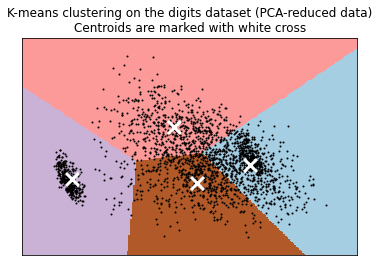

In [44]:
data = df[feats_emb]
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.005  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 0.1, reduced_data[:, 0].max() + 0.1
y_min, y_max = reduced_data[:, 1].min() - 0.1, reduced_data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
clustering.predict([0 for i in range(412)])

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
class Vector():
    id: int
    data: list[float]

def root(vectors: list[Vector]):
    clusters = []
    for vec in vectors:
        clusters.append(clustering.predict(np.array(vec.data)).reshape(1,-1))
    result = [[] for i in range(4)]
    for i, cluster in enumerate(clusters):
        result[cluster].append(vectors[i])
    return result

In [67]:
vectors = []
for i in range(df.shape[0]):
    vec = Vector()
    vec.id = i
    vec.data = df.iloc[i][feats_emb].values
    vectors.append(vec)

In [68]:
vectors[i].data

array([-0.01746392995119095, -0.035793088376522064, -0.060010820627212524,
       -0.03343423455953598, 0.10821670293807983, -0.044904690235853195,
       -0.07044145464897156, -0.057371485978364944, 0.006555585190653801,
       0.02954528108239174, 0.06967194378376007, -0.0011611069785431027,
       0.07193094491958618, 0.03302808851003647, 0.0061102663166821,
       0.0016663059359416366, 0.06773305684328079, 0.004526031203567982,
       -0.0023943271953612566, 0.040137000381946564, 0.03159103915095329,
       0.0013770030345767736, 0.04246697574853897, 0.014882595278322697,
       0.06497085839509964, 0.01984575390815735, 0.0359848253428936,
       0.0009470066870562732, 0.01625153236091137, 0.037660736590623856,
       -0.004364545922726393, 0.0012015545507892966,
       -0.008504723198711872, 0.007596216630190611, -0.001992597011849284,
       -0.010997858829796314, -0.01929342746734619, 0.0035915635526180267,
       -0.00839510653167963, 0.01935724727809429, 0.014154363423585892,

In [69]:
ans = root(vectors)

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[ 3.70138437e-02 -6.92161396e-02 -5.90910055e-02 -9.98945627e-03
  2.59098876e-02 -9.18104034e-03 -1.11116469e-02 -8.79214481e-02
 -2.73359064e-02  9.93299391e-03  1.11751156e-02  1.16749024e-02
  5.57900071e-02  1.13637024e-03 -9.88955889e-03 -1.76482722e-02
  5.29124700e-02  1.90837346e-02  2.73871273e-02  7.54561648e-02
 -5.35081737e-02 -4.03390042e-02 -1.49794146e-02  8.09115451e-03
  3.36822756e-02  4.47824784e-02  5.38013875e-02  3.35569121e-02
  3.17540616e-02  1.79870576e-02  2.61568632e-02  1.99537668e-02
  5.80082014e-02  1.64048728e-02 -2.20077159e-03  3.61325666e-02
 -1.91341043e-02 -1.65935885e-02 -1.27085932e-02  2.06453595e-02
 -9.44244713e-02  1.15343273e-01  2.46332623e-02 -1.39344446e-02
  3.88536556e-03  1.11739598e-02  6.73530698e-02 -2.63918694e-02
  7.01097995e-02  1.24881333e-02  7.68445581e-02 -4.86623049e-02
  3.54139432e-02  1.91852171e-02 -6.43005148e-02 -5.15183434e-02
  3.07390913e-02 -1.42602259e-02  7.59565532e-02  4.80067590e-03
  4.48131897e-02  4.40820269e-02  3.43245431e-03 -2.70328596e-02
  1.44492555e-02  6.61770031e-02 -1.11960120e-01 -6.62850589e-02
 -2.00507436e-02 -1.80821475e-02 -5.73630147e-02  3.32366489e-02
 -5.81890084e-02 -2.54186243e-02 -6.50608819e-03 -2.07662495e-04
  4.92301062e-02  4.49014008e-02 -1.38062565e-02  1.07669448e-02
  1.97199918e-02  3.95827293e-02 -4.73588593e-02 -2.25179344e-02
  7.95040205e-02 -6.90532848e-02 -3.62793691e-02 -7.75941387e-02
  1.59713090e-03 -8.75165779e-03  2.64094435e-02 -1.97908655e-02
 -2.18255911e-02  3.51647064e-02  1.02310476e-03 -3.53281945e-02
  1.14437763e-03  1.10700622e-01 -6.99760839e-02  6.80721737e-03
  2.72437446e-02  6.65472075e-03 -8.08750987e-02  1.43416040e-02
 -1.18603799e-02 -1.87842455e-02 -2.49182545e-02 -7.96527267e-02
 -1.12430081e-02  6.35055453e-02  1.39281983e-02 -5.85202575e-02
  7.33057708e-02  3.69217731e-02 -3.27385589e-02  4.41420358e-04
  2.35709008e-02 -4.30412553e-02  4.43672575e-02 -5.85054085e-02
  3.67133468e-02 -1.45151634e-02  5.25080878e-03  6.61043301e-02
  1.11772858e-01  8.49697515e-02  2.39233095e-02  8.54797475e-03
 -2.58992705e-02 -4.22341712e-02  2.81430464e-02  1.74201243e-02
 -3.00968178e-02  2.60169990e-02  3.05024534e-02 -1.99748371e-02
  3.01863998e-02  2.40557594e-03  1.61014460e-02 -5.59472200e-03
 -1.49245299e-02  1.76464140e-01  3.68229374e-02  2.95099523e-02
 -1.25084883e-02 -2.33030226e-02 -6.97996654e-03  3.31752165e-03
 -3.03919911e-02  4.20752168e-02  2.08643209e-02  2.15528961e-02
  9.41788964e-03  6.56337757e-03  2.98188832e-02 -4.10018582e-03
  1.50987441e-02 -9.91592109e-02 -3.56231555e-02  3.04309502e-02
  3.24531831e-02  1.05057955e-01  4.42448594e-02 -7.82313757e-03
 -1.77171279e-03  4.15900573e-02 -9.36028082e-03 -2.72932351e-02
  3.94742824e-02 -3.87762785e-02  5.29940538e-02  3.33800749e-03
 -3.05838957e-02 -2.40363684e-02 -3.53202894e-02 -6.97530285e-02
 -8.71200114e-03  2.04689242e-02  3.67557891e-02  2.46832496e-03
 -8.28759000e-03  5.18459678e-02 -3.65944207e-02 -2.03379411e-02
  6.57682270e-02  3.77335697e-02  6.28844276e-03 -7.57629946e-02
  1.32184755e-02 -4.38312329e-02  1.12286415e-02 -2.55934373e-02
 -3.95487696e-02  6.05929680e-02  1.38025992e-02  8.65740143e-03
  7.62778446e-02 -4.51631844e-03 -4.25826274e-02  1.45193292e-02
 -4.70822044e-02  4.54296842e-02 -1.12446174e-02 -9.13460739e-03
  3.25861573e-02  2.28972081e-02 -3.27333086e-03  1.49128148e-02
  7.81924743e-03  4.53165770e-02 -2.76910122e-02  2.32359357e-02
  7.11277779e-03  1.20851593e-02  1.12467334e-02  2.08805483e-02
  1.90988909e-02  1.91968363e-02 -2.44781114e-02  2.11738260e-03
 -3.62083428e-02 -3.95521894e-02 -1.38161043e-02  2.88598961e-03
 -1.71625670e-02  2.78955456e-02 -2.56516435e-03  6.04460984e-02
  1.95554532e-02  4.66371030e-02 -3.71049717e-02 -7.75809884e-02
 -4.37383950e-02 -1.10249296e-02 -5.27552664e-02  5.25622070e-03
  5.76296411e-02 -6.45216256e-02  3.05540711e-02  4.08959799e-02
  7.40584582e-02  6.04398102e-02 -1.07603278e-02 -2.97393091e-02
  4.20772955e-02  1.08507462e-02 -1.39023568e-02  4.58924240e-03
  5.16669601e-02  3.16884108e-02  8.32927525e-02  4.40546647e-02
  4.98499162e-02 -2.43249312e-02 -5.60469963e-02  1.79771695e-03
  4.22714427e-02  6.13679690e-03  1.45756125e-01 -1.55730569e-03
  3.29922922e-02  4.74998541e-02  5.89175634e-02 -6.93386495e-02
  8.89398810e-03  2.30087172e-02 -1.84791833e-02 -1.26896454e-02
 -1.71300117e-02 -3.86822387e-03  4.81042340e-02 -5.13464585e-02
  1.85499024e-02 -8.39067623e-02 -2.95229023e-04  1.02291636e-01
  2.85045453e-03  3.71891074e-02 -8.18673149e-02 -5.12505062e-02
 -4.65089604e-02  7.53054619e-02  2.49445774e-02 -6.65995106e-02
 -4.21220325e-02 -1.97136346e-02 -2.12243255e-02 -1.28302602e-02
  1.66369788e-02  1.23532554e-02  5.92505857e-02 -5.01122586e-02
 -7.34680668e-02  1.52834635e-02 -7.43754627e-03 -5.66960514e-01
 -1.57150812e-03  1.22456939e-03  3.95841226e-02 -2.38080248e-02
 -2.50513721e-02  8.57119157e-04  4.54759672e-02 -8.07396602e-03
 -3.57552767e-01  1.97217967e-02 -9.74891242e-03 -5.02358340e-02
  5.59488870e-02  1.98189542e-02 -5.66214360e-02  2.24219612e-03
 -3.09502352e-02  7.28102177e-02  7.99024850e-03  4.58415747e-02
 -1.66603923e-02  3.54874209e-02  1.21489996e-02 -6.33570254e-02
  7.69387698e-03  3.13548781e-02  2.32835710e-02 -8.12068507e-02
  4.17594686e-02  6.53509349e-02 -2.80367285e-02 -3.81097756e-02
 -8.72002840e-02 -2.43710726e-02 -9.75320814e-04 -3.99045460e-02
  7.49792084e-02  5.79366125e-02 -5.23482412e-02  3.27911191e-02
  2.53744051e-02  1.62151363e-02  5.48300669e-02 -5.32638133e-02
  6.05819747e-03  7.02361166e-02  3.30594890e-02 -1.07540535e-02
 -1.01865465e-02  4.20445502e-02 -6.78997068e-03 -4.07009199e-03
 -3.49005610e-02 -1.02180369e-01  1.52207837e-02  2.34438572e-02
 -5.25384285e-02  3.85459848e-02 -2.52797212e-02 -1.43012218e-02
  3.78533751e-02  5.44131249e-02 -1.28419849e-03  3.99172790e-02
  1.15801170e-01  1.43577382e-02 -1.94994081e-02 -1.53750507e-02
  3.15078758e-02  3.80905196e-02 -2.69807875e-02  3.00924033e-02
  1.15066841e-01  2.44745519e-02 -4.88741696e-03  4.21066172e-02
  8.11941922e-03  1.21393679e-02  1.46071194e-02 -2.21241247e-02
  3.27505060e-02 -3.92185990e-03  1.06242588e-02 -1.83439702e-02
  7.42635205e-02 -7.40371470e-04 -3.45932506e-02  8.73345602e-03
  1.42974807e-02  1.71885509e-02  4.62429486e-02  2.27620192e-02
  1.12565863e-03  8.01937059e-02  1.25663104e-02  5.34074381e-03
  5.95516246e-03 -5.67704737e-02 -2.80849691e-02  1.85012184e-02
 -3.03509692e-03 -6.92690397e-03 -5.09292036e-02 -1.48881115e-02
  3.27505823e-03 -3.70401107e-02  2.08404083e-02 -4.40190844e-02
 -1.08533325e-02  1.04024336e-01 -1.27407201e-02  7.44614378e-03
  4.63626571e-02 -6.76694214e-02 -4.64964984e-03 -4.21044081e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.